<a href="https://colab.research.google.com/github/lukemerrick/image-text-embedding/blob/main/initial_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploration

# Load the MetaCLIP 1.2 model

In [ ]:
# Get code to load the latest MetaCLIP model.
!git clone https://github.com/facebookresearch/MetaCLIP.git ./MetaCLIP
!mv ./MetaCLIP/src ./src
!rm -rf ./MetaCLIP

# Download the latest MetaCLIP model weights.
!wget -q --show-progress https://dl.fbaipublicfiles.com/MMPT/metaclip/h14_v1.2_altogether.pt

Cloning into './MetaCLIP'...
remote: Enumerating objects: 686, done.
remote: Counting objects: 100% (200/200), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 686 (delta 107), reused 129 (delta 70), pack-reused 486 (from 2)
Receiving objects: 100% (686/686), 25.62 MiB | 7.21 MiB/s, done.
Resolving deltas: 100% (269/269), done.
h14_v1.2_altogether 100%[===================>]   3.67G  23.6MB/s    in 2m 40s  


In [ ]:
from src.open_clip.factory import create_model_and_transforms
from src.open_clip.tokenizer import tokenize
import torch

In [ ]:
# model, _, preprocess = create_model_and_transforms('ViT-H-14')
# state_dict = torch.load("./h14_v1.2_altogether.pt", weights_only=True)["state_dict"]
# model.load_state_dict(state_dict)

# NOTE: Temporarily use faster model.
model, _, preprocess = create_model_and_transforms('ViT-B-32-quickgelu')
model = model.cuda()

# Load the Flicker30k dataset

In [ ]:
!wget -q --show-progres https://huggingface.co/datasets/nlphuji/flickr30k/resolve/main/flickr30k-images.zip

flickr30k-images.zi 100%[===================>]   4.09G  4.68MB/s    in 3m 5s   


In [ ]:
!wget -q --show-progress https://huggingface.co/datasets/nlphuji/flickr30k/resolve/main/flickr_annotations_30k.csvjpg

flickr_annotations_ 100%[===================>]  12.30M  27.3MB/s    in 0.5s    


In [ ]:
!unzip ./flickr30k-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr30k-images/434938585.jpg  
  inflating: __MACOSX/flickr30k-images/._434938585.jpg  
  inflating: flickr30k-images/3260088697.jpg  
  inflating: __MACOSX/flickr30k-images/._3260088697.jpg  
  inflating: flickr30k-images/4857774876.jpg  
  inflating: __MACOSX/flickr30k-images/._4857774876.jpg  
  inflating: flickr30k-images/4410008455.jpg  
  inflating: __MACOSX/flickr30k-images/._4410008455.jpg  
  inflating: flickr30k-images/2931392634.jpg  
  inflating: __MACOSX/flickr30k-images/._2931392634.jpg  
  inflating: flickr30k-images/3066429707.jpg  
  inflating: __MACOSX/flickr30k-images/._3066429707.jpg  
  inflating: flickr30k-images/350426761.jpg  
  inflating: __MACOSX/flickr30k-images/._350426761.jpg  
  inflating: flickr30k-images/6141695796.jpg  
  inflating: __MACOSX/flickr30k-images/._6141695796.jpg  
  inflating: flickr30k-images/149806768.jpg  
  inflating: __MACOSX/flickr30k-images/._149806768.jpg  
  inflatin

In [ ]:
from pathlib import Path
from PIL import Image
import torch.nn.functional as F

image_dir = Path("flickr30k-images")
image_paths = sorted(image_dir.glob("*.jpg"))
print(f"Found {len(image_paths):,} jpg files")
example_image_path = image_paths[0]
example_image = Image.open(example_image_path)


Found 31,783 jpg files


In [ ]:
import pandas as pd

df = pd.read_csv("./flickr_annotations_30k.csv")

# We have files for all the annotations, but not necessarily the other way around.
assert len(set(df["filename"]) - set(fp.name for fp in image_paths)) == 0, "missing files"

print(f"Loaded {df.shape[0]:,} annotations")
df.sample(5, random_state=0).sort_index()

Loaded 31,014 annotations


raw  \
6910   ["Three naked people ride bicycles in a city s...   
11677  ["A person helping a toddler with red pants wa...   
16175  ["Chubby man holding camera on tripod, standin...   
22498  ["Happy couple riding bikes side by side with ...   
30405  ["A marathon runner wearing a numbered bib is ...   

                                        sentids  split        filename  img_id  
6910        [34550, 34551, 34552, 34553, 34554]  train  2581066814.jpg    6910  
11677       [58385, 58386, 58387, 58388, 58389]  train  3199600309.jpg   11677  
16175       [80875, 80876, 80877, 80878, 80879]    val  3736180463.jpg   16175  
22498  [112490, 112491, 112492, 112493, 112494]  train  4763448557.jpg   22498  
30405  [152025, 152026, 152027, 152028, 152029]  train  8154663567.jpg   30405

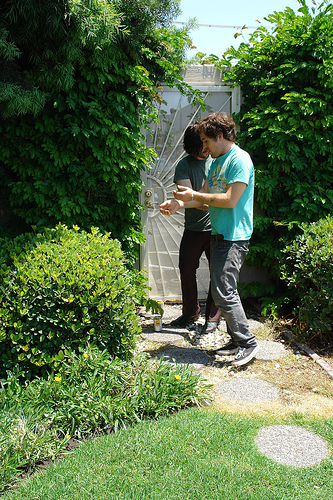

In [ ]:
example_image

# Embed all the images in Flickr30k

NOTE: We may at some point want to subset to non-training examples, but it may also be okay to use all the images since Flickr30k is an old dataset not that useful for training anymore.

In [ ]:

def load_image_by_filename(name: str) -> torch.Tensor:
  with Image.open(image_dir / name) as img:
    return preprocess(img).unsqueeze(0)

def load_image_batch(names: list[str]) -> torch.Tensor:
  return torch.row_stack([load_image_by_filename(x) for x in names])

In [ ]:
BATCH_SIZE = 32
filenames = df["filename"].tolist()
batched_filenames = [filenames[start:start+BATCH_SIZE] for start in range(0, df.shape[0], BATCH_SIZE)]

# NOTE: Multiprocessing doesn't seem to speed things up much here.
# from multiprocessing.pool import ThreadPool, Pool
# with Pool(4) as pool, tqdm(total=len(filenames), unit="image", smoothing=0) as pbar:
#   res_iter = pool.imap(load_image_batch, batched_filenames)
#   for batch in res_iter:
#     assert batch.size(0) == BATCH_SIZE
#     pbar.update(batch.size(0))

In [ ]:
from tqdm.auto import tqdm
import numpy as np

res = []
with tqdm(total=df.shape[0], unit="image") as pbar, torch.inference_mode():
  for batch_filenames in batched_filenames:
    image_batch = load_image_batch(batch_filenames).cuda()
    image_features = model.encode_image(image_batch)
    image_features = F.normalize(image_features, dim=-1)
    res.append(image_features.cpu().numpy())
    pbar.update(image_batch.size(0))

  0%|          | 0/31014 [00:00<?, ?image/s]

In [ ]:
res = np.row_stack(res)

In [ ]:
res.shape

(31014, 512)

In [ ]:
np.save("./clip_embedded_flickr30k.npy", res)

In [128]:
from sklearn.cluster import MiniBatchKMeans, KMeans

In [129]:
kmeans = KMeans(n_clusters=30, max_iter=500)

In [130]:
%%time
clusters = kmeans.fit_predict(res)

CPU times: user 9.6 s, sys: 1.1 s, total: 10.7 s
Wall time: 10.9 s


In [131]:
cluster_counts = pd.Series(clusters).value_counts()
cluster_counts.iloc[[0, 1, 2, -3, -2, -1]]

2     2187
9     1860
26    1724
23     490
18     467
3      419
Name: count, dtype: int64

A green train getting ready to enter a tunnel, along with the train conductor who is wearing a blue hat and shirt.
This is a railroad engineer working on a green and red tourism train in a theme park.
A man is sitting on a green train that is about to go through a tunnel.
A small tourist train approaching a tunnel.
A man driving a green miniature train.


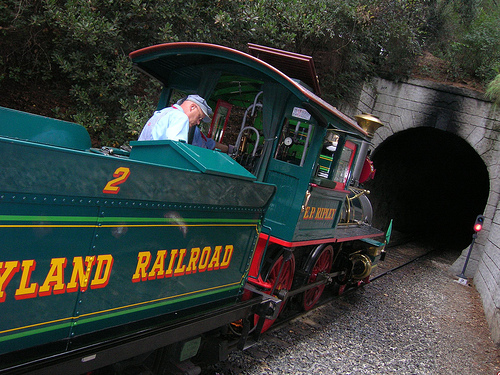

A woman in a yellow hat and yellow shirt holding her hand out like a claw.
A woman wearing glasses and a yellow shirt is holding her hand out.
Woman with a yellow hat and yellow shirt speaking.
A woman in a yellow hat is talking.
Woman speaking in a kitchen.


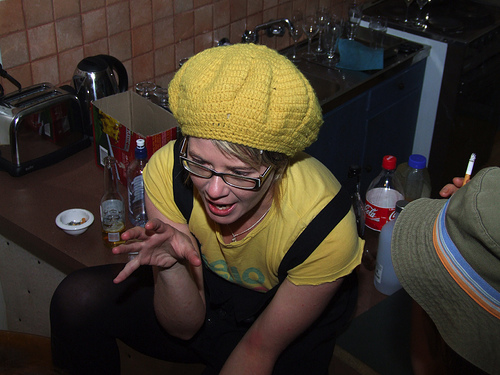

Two people being photographed from behind sitting on a bus
Two people are sitting on a tram during the nighttime.
The back of two people sitting on one seat in a bus.
Two people are sitting on the bus at nighttime.
A man sits next to a woman on a bus.


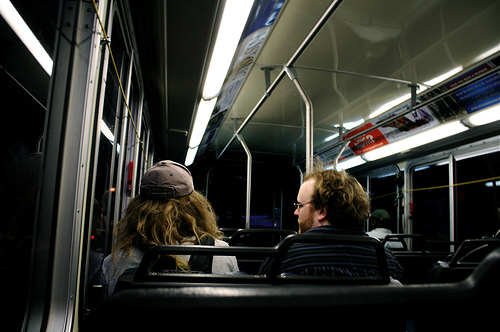

Someone in a black dress and a tan colored hat, selling fruit and vegetables on the road.
A Lady with a variety of produce vending in the shade and weighing a slice of fruit.
This woman is setting out a vegetable collection for sale in the market.
A black woman with a hat on is weighing fruits and vegetables.
A lady is weighing produce on a scale.


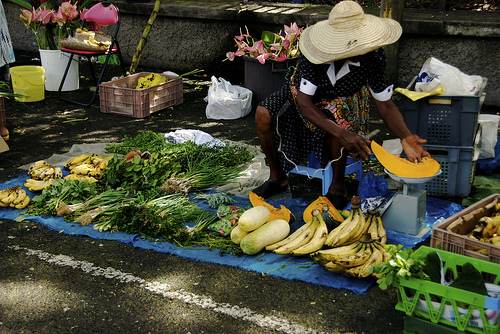

Two men are working in the dark and only have the headlights of their truck to see by.
Two men stand on a dark snowy street as a snow plow approaches.
Two men working outdoors at night in the snow.
Two men are out in the snow with a snow plow.
A snow plow is coming towards two people.


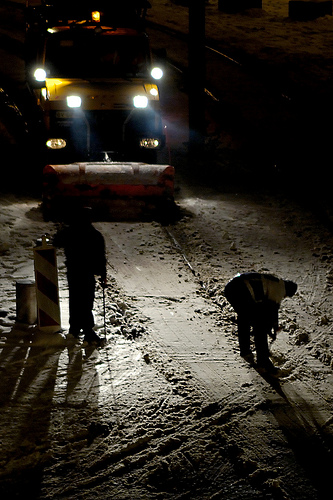

A woman wearing a tan overcoat and black boots is walking down the street while carrying a white bag over her right shoulder.
A woman in a mustard dress with a white purse is walking down the street in front of a brick building.
Lady in yellow turning corner of a sidewalk.
A woman walking on street with white purse.
A woman walking down a sidewalk.


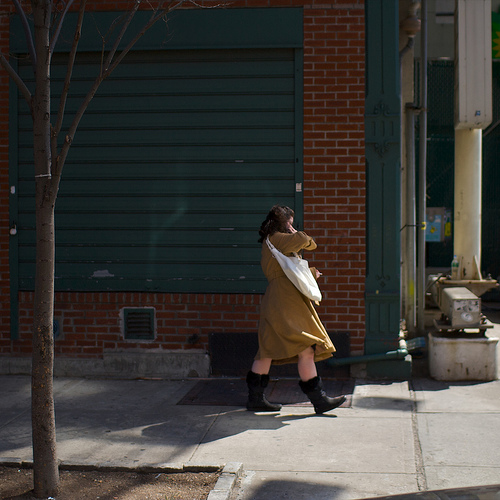

A man wearing glasses and with a beer in his left hand and his dog in his right hand being seated in a love seat.
A man wearing glasses is seated holding a small dog on a leash and a long neck bottle
A man holds a dog and a beer while sitting in a floral armchair.
A man is sitting in a chair with his dog and a beer in hand.
A man is sitting with his brown and white dog.


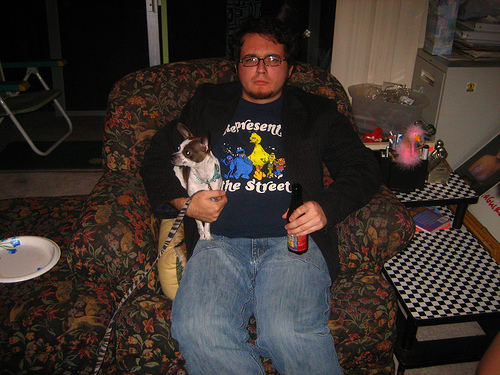

A man wearing a gray sweatshirt play electric guitar and a man in a black sleeveless shirt drums while a crowd of people watches from behind them.
A man is playing the guitar while another man plays the drums in front of a crowd of people.
A young male figure plays guitar in front of a drummer, while an audience crowds nearby.
A band plays with the guitar in front for a crowd.
A band playing in front of a crowd of people


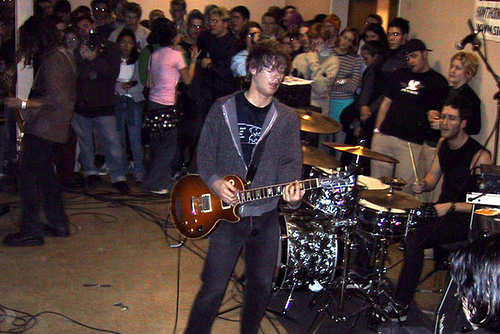

There is a woman, several men, and several children on a sidewalk where produce is being sold.
Two small girls stand in front of a fruit stand and a group older people stand nearby.
There are two men sitting on the floor while a woman watches them.
There are several people standing in the marketplace.
Children standing at the fruit stand in the market.


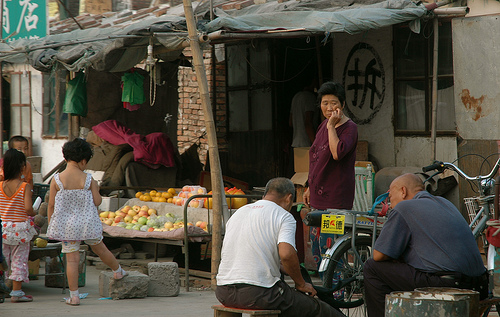

A white crane flying through the air over some water.
A large white bird flying over water.
A stork flying low over the water.
A white heron flies into the sky.
A swan is flying above water.


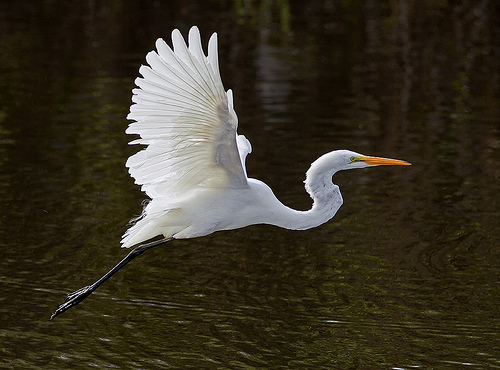

In [132]:
import json
top_cluster_annotations = df.iloc[clusters == cluster_counts.index[0]]
for captions_json, filename in top_cluster_annotations.sample(10, random_state=0)[["raw", "filename"]].itertuples(index=False):
  for cap in json.loads(captions_json):
    print(cap)
  display(Image.open(image_dir / filename))
  print("=" * 40)